# TP OMA 2: Stochastic first order methods

## 1 - Linear regression

In this pratical exercise, we will train again a linear regression model as in TP1 but using stochastic first order methods as seen in the lectures.

Recall the following:

In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute $f(x^*)$ using the normal equations ($x^*=(A^T A)^{-1} A^T b$). 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

### Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown \texttt{scikit-learn} machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [2]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0)
    return X,Y

In [3]:
n=10000
d=10

X,Y=generate_dataset(n,d)
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]


X= [[ 0.5119392  -0.51257393 -0.39873458 ...  0.79216612  0.10915074
  -0.0951405 ]
 [ 0.90287683 -1.53836899  0.80133871 ...  0.13737646  1.29707674
  -0.23400236]
 [-2.02247319 -1.77334687 -1.08489379 ... -0.90549415  0.07430919
  -0.04475356]
 ...
 [ 0.55801893 -1.75346641 -0.96717889 ... -0.02467231 -0.65008331
   1.97355577]
 [-1.45656701 -1.17026255 -0.12040334 ...  0.20070767 -0.0534915
   0.8883705 ]
 [ 1.28001308 -0.13720549  0.69245318 ...  1.46369757  1.23085467
   0.54181686]]
Y= [ 3.42760927e-01  1.13239255e+02 -3.97654082e+02 ...  9.29517289e+01
 -3.59156712e+00  1.48150884e+02]


### Computing $f(x^*)$

In [4]:
def full_objective(Y, A, x):
    #compute the least square loss 
    return np.linalg.norm(Y - A.dot(x))**2

In [5]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)
print(x_star)


f(x*) =  990587.9862129582
[ 1.85554911 85.93291409 19.93043355 68.55460877 37.37959455 59.71052011
 18.13326927 27.64675668 51.0127487  23.30429496 85.31188854]


### Benchmark: gradient descent

In [21]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    grad = -1/n * A.T @ (Y - A @ x)
    return grad

def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x - lr * grad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives, gd_iterates = gradient_descent(
    Y, A, x_initial, nmax, lr)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))


GD(0000/0000/9999): objective = 239089464.77
GD(0001/0001/9999): objective = 192960892.69
GD(0002/0002/9999): objective = 155781265.87
GD(0003/0003/9999): objective = 125812177.65
GD(0004/0004/9999): objective = 101653361.11
GD(0005/0005/9999): objective = 82176833.40
GD(0006/0006/9999): objective = 66473881.94
GD(0007/0007/9999): objective = 53812385.29
GD(0008/0008/9999): objective = 43602451.63
GD(0009/0009/9999): objective = 35368751.76
GD(0010/0010/9999): objective = 28728240.88
GD(0011/0011/9999): objective = 23372218.19
GD(0012/0012/9999): objective = 19051878.60
GD(0013/0013/9999): objective = 15566676.05
GD(0014/0014/9999): objective = 12754950.54
GD(0015/0015/9999): objective = 10486378.02
GD(0016/0016/9999): objective = 8655888.04
GD(0017/0017/9999): objective = 7178763.64
GD(0018/0018/9999): objective = 5986693.29
GD(0019/0019/9999): objective = 5024589.57
GD(0020/0020/9999): objective = 4248025.76
GD(0021/0021/9999): objective = 3621169.84
GD(0022/0022/9999): objective = 3

### Stochastic gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [22]:
def minibatch_gradient(Y_batch, A_batch, x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param Y_batch: a numpy array of shape (batch_size)
    :param A_batch: a numpy array of shape (batch_size, d)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (d)
    
    :return: stoc_grad: numpy array of shape (d)
    """
    
    stoc_grad = -1/len(Y_batch) * A_batch.T @ (Y_batch - A_batch @ x)
    return stoc_grad


Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [67]:
def stoc_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr, batch_size):
    """
    Stochastic gradient descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param batch_size: number of samples used for calculating the stochastic gradient 
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        n=len(Y)
        #randomly get a batch of data
        indices = np.random.choice(n, batch_size, replace=False)
        Y_batch = Y[indices]
        A_batch = A[indices]


        grad = minibatch_gradient(Y_batch, A_batch, x)
        # update x through the gradient update
        x = x - lr * grad
        lr = lr * 0.99
        
            
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your SGD on the regression problem you have generated earlier. You may try several values for the step size and various type of step sizes (constant, diminishing).

In [68]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.05
batch_size=10

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
stocgd_objectives, stocgd_iterates = stoc_gradient_descent(
    Y, A, x_initial, nmax, lr,batch_size)
end_time = datetime.datetime.now()

# Print result
execution_time_sgd = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=execution_time))

SGD(0000/0000/9999): objective = 272580506.07
SGD(0001/0001/9999): objective = 255024981.32
SGD(0002/0002/9999): objective = 208831044.76
SGD(0003/0003/9999): objective = 192583124.22
SGD(0004/0004/9999): objective = 179160032.98
SGD(0005/0005/9999): objective = 146441532.83
SGD(0006/0006/9999): objective = 127366342.35
SGD(0007/0007/9999): objective = 109389478.78
SGD(0008/0008/9999): objective = 106693629.00
SGD(0009/0009/9999): objective = 98648130.51
SGD(0010/0010/9999): objective = 91444335.66
SGD(0011/0011/9999): objective = 84897083.56
SGD(0012/0012/9999): objective = 83049283.70
SGD(0013/0013/9999): objective = 76916948.50
SGD(0014/0014/9999): objective = 67981643.19
SGD(0015/0015/9999): objective = 58173389.35
SGD(0016/0016/9999): objective = 51192098.59
SGD(0017/0017/9999): objective = 48219057.54
SGD(0018/0018/9999): objective = 45782552.75
SGD(0019/0019/9999): objective = 42328891.10
SGD(0020/0020/9999): objective = 37252045.51
SGD(0021/0021/9999): objective = 34099224.82
S

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:


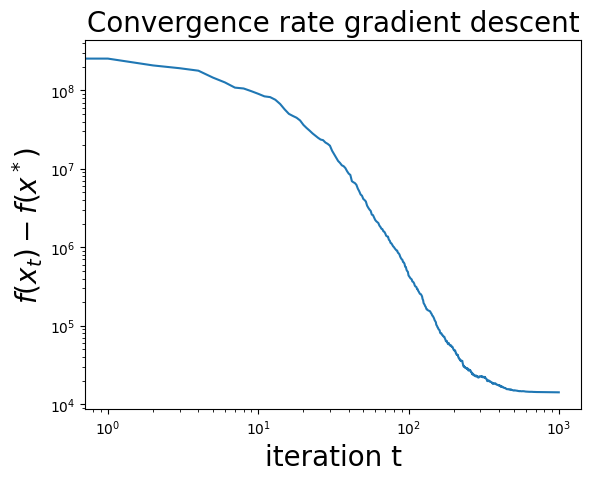

In [69]:
plt.title('Convergence rate gradient descent', fontsize = 20)
plt.loglog(stocgd_objectives - best_objective)
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.show()

Compare your results with the classic (full batch) gradient method.

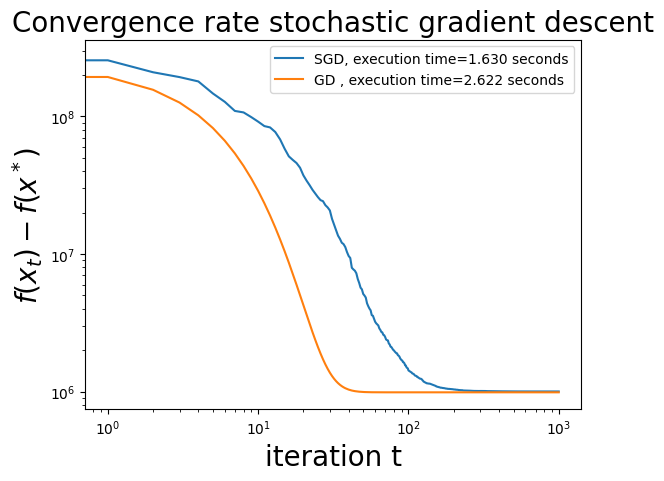

In [70]:
#plot convergence of SGD vs regular GD
plt.title('Convergence rate stochastic gradient descent', fontsize = 20)
plt.loglog(stocgd_objectives, label='SGD, execution time={t:.3f} seconds'.format(t=execution_time_sgd))
plt.loglog(gd_objectives, label='GD , execution time={t:.3f} seconds'.format(t=execution_time))
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend()


## 2 - Support Vector Machine

In this section, we will implement a stochastic (sub)-gradient algorithm in order to solve the soft primal margin SVM training problem. Recall the problem:
$$
\displaystyle \min_{w,b} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{n} \max\{0,1-y_i(w^Tx_i+b)\} 
$$
where $C$ is a parameter. In the following, we will write $\theta=(w,b)$ where $w=(\theta_1,\ldots,\theta_d)$ and $b=\theta_{d+1}$.

Let us first import libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.utils import shuffle

Then define a function to generate two clusters of 2D data point that we will try to separate using the SVM. The number of points generated is a parameter of the function.

In [54]:
def generatedata2(n):
    # n must be an even integer
    np.random.seed(0)
    mean1, cov1, n1 = [1, 5], [[1,1],[1,2]], int(n/2)  # n/2 samples of class 1
    x1 = np.random.multivariate_normal(mean1, cov1, n1)
    y1 = np.ones(n1, dtype=int)
    mean2, cov2, n2 = [2.5, 2.5], [[1,0],[0,1]], int(n/2) # n/2 samples of class -1
    x2 = np.random.multivariate_normal(mean2, cov2, n2)
    y2 = -np.ones(n2, dtype=int)
    x = np.concatenate((x1, x2), axis=0) # concatenate the samples
    y = np.concatenate((y1, y2))
    x,y = shuffle(x,y)
    
    return [x,y]

Let us now define a function that will plot the data and a function to plot the hyperplane (and the supporting hyperplanes) generated by the SVM and represented in the form of $\theta=(w,b)$ (meaning $w^Tx+b=0$).

In [55]:
def plotdata(x,y):
    for i in range(x.shape[0]):
        if y[i]==-1:
            cl='bo';
        else:
                cl='r+';
        plt.plot(x[i,0],x[i,1],cl);
    return

def plothyperplane(w,b):
    xx=np.linspace(x[:,0].min(),x[:,0].max(),100);
    #print(xx)
    yy=(-b-w[0]*xx)/w[1];
    yy1=yy+1/np.linalg.norm(w);
    yy2=yy-1/np.linalg.norm(w);
    #print(yy)
    plt.plot(xx,yy,'k-')
    plt.plot(xx,yy1,'g-')
    plt.plot(xx,yy2,'g-')
    return

Define first the function that computes the value of the SVM problem objective function at $\theta$.

In [63]:
def SVMobjective(x, y, d, C, theta):
    w = theta[:d]
    b = theta[d]
    hinge_losses = np.maximum(0, 1 - y * (x @ w + b))
    return 0.5 * np.linalg.norm(w)**2 + C * np.sum(hinge_losses)

Define now a new function that will take as parameters a batch of samples $(x_i,y_i)_{i=1,\ldots,batch_size}$ and return a stochastic subgradient of the objective function at $\theta$ by considering only the terms of the batch. 

In [64]:
def minibatch_subgrad_svm(x_batch,y_batch,d,C,theta):
    w = theta[:d]
    b = theta[d]
    margins = y_batch * (x_batch @ w + b)
    mask = margins < 1
    subgrad_w = w - C * np.mean(y_batch[mask, np.newaxis] * x_batch[mask], axis=0)
    subgrad_b = -C * np.mean(y_batch[mask]) if np.any(mask) else 0
    subgrad = np.concatenate([subgrad_w, [subgrad_b]])
    return subgrad

Use the above function to implement the following svm_SGD algorithm:

In [65]:
def svm_SGD(x,y,d,C,theta,batch_size,lr,nmax):
    
    thetas = [theta]
    objectives = []
    for epoch in range(nmax):
        for iter in range(int(len(y)/batch_size)):
            indices = np.random.choice(n, batch_size, replace=True)
            SVMgrad=minibatch_subgrad_svm(x[indices],y[indices],d,C,theta)
        
            # update x through the gradient update
            theta -= lr * SVMgrad
                
            # store x and objective
            thetas.append(theta.copy())
            objective=SVMobjective(x,y,d,C,theta)
            objectives.append(objective)
            print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                          bi=epoch, ti=len(y) - 1, l=objective))
    return objectives, thetas


SGD(0000/0000/0999): objective =    7869.23
SGD(0000/0000/0999): objective =    6791.78
SGD(0000/0000/0999): objective =    5878.25
SGD(0000/0000/0999): objective =    4408.77
SGD(0000/0000/0999): objective =    3788.99
SGD(0000/0000/0999): objective =    3975.81
SGD(0000/0000/0999): objective =    3547.77
SGD(0000/0000/0999): objective =    4118.90
SGD(0000/0000/0999): objective =    4467.43
SGD(0000/0000/0999): objective =    3259.73
SGD(0001/0001/0999): objective =    2820.54
SGD(0001/0001/0999): objective =    3508.82
SGD(0001/0001/0999): objective =    2384.96
SGD(0001/0001/0999): objective =    2835.10
SGD(0001/0001/0999): objective =    2548.12
SGD(0001/0001/0999): objective =    2254.11
SGD(0001/0001/0999): objective =    2528.77
SGD(0001/0001/0999): objective =    4017.73
SGD(0001/0001/0999): objective =    2665.39
SGD(0001/0001/0999): objective =    2363.35
SGD(0002/0002/0999): objective =    2514.01
SGD(0002/0002/0999): objective =    3062.11
SGD(0002/0002/0999): objective =

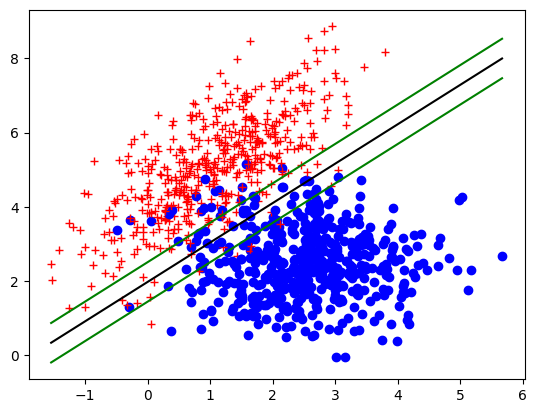

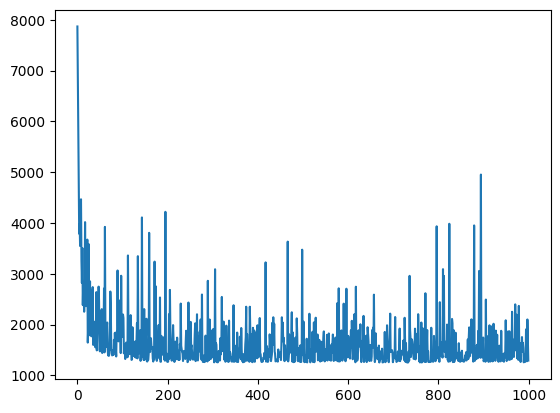

In [66]:
plt.close("all");

d=2
n=1000
C=10
nmax=100
lr=0.01
batch_size=100

[x,y]=generatedata2(n)

plt.figure(0)
plotdata(x,y)

theta_initial=np.empty([d+1])
theta_initial[:d]=np.zeros([2])
theta_initial[d]=0

obj=np.empty(nmax)
objectives, thetas = svm_SGD(x,y,d,C,theta_initial,batch_size,lr,nmax)
predict=np.empty(n)
w=thetas[-1][:d]
b=thetas[-1][d]

error=0
for j in range(n):
    predict[j]=np.sign(np.dot(x[j,:],w)+b)
    if y[j]!=predict[j]:
        error+=1
plothyperplane(w,b)

#error
training_error=error*100/n
print('Training error=',training_error)

plt.figure(1)
plt.plot(range(len(objectives)),objectives)